In [1]:
# module cell

import ROOT
import math
from math import sin,cos
from ROOT import TRandom3
from ROOT import TMVA
from array import array
import numpy as np

Welcome to JupyROOT 6.20/00


## Creating a Signal and Background

Suppose we are detecting electron from ionisation detector which only detects electron or muon. One says we have 95% sure that the detected particles are electron. Lets try to verify the statement. 

First construct a distribution of electron or your $\textbf{ Null Hypothesis H0}$ and the muon distribution $\textbf{H1}$. The variable is $\frac{dE}{dx}$ and $\frac{dE}{dy}$. It is a wrong example we actually don't have $\frac{dE}{dy}$ I just consider for better Training, In real case you can consider other variable like invariant mass or something.

In [2]:
file = ROOT.TFile('InputFile.root','recreate')
Sig = ROOT.TTree('Sig','Electron distribution')
Bkg = ROOT.TTree('Bkg','Muon distribution')
dEdx = array('f',[0])
dEdy = array('f',[0])
Sig.Branch('dEdx',dEdx,'dEdx/F')
Sig.Branch('dEdy',dEdy,'dEdy/F')
Bkg.Branch('dEdx',dEdx,'dEdx/F')
Bkg.Branch('dEdy',dEdy,'dEdy/F')

rand = TRandom3(1234)
NEvents = 10000
r0,sigma= 2.0,0.5

#creating Signal
for evt in range(NEvents):
    dEdx[0] = sigma*rand.Gaus()
    dEdy[0] = sigma*rand.Gaus()
    Sig.Fill()
    
#creating Background
for evt in range(NEvents):
    r = rand.Rndm()*0.7
    x0 = r0*cos(r*math.pi)
    y0 = r0*sin(r*math.pi)
    dEdx[0] = x0 + sigma*rand.Gaus()
    dEdy[0] = y0 +sigma*rand.Gaus()
    Bkg.Fill()
    
file.Write()
file.Close()

A root file created in your current directory. you can find two trees in the file one is for signal and background. We could see the distributions.

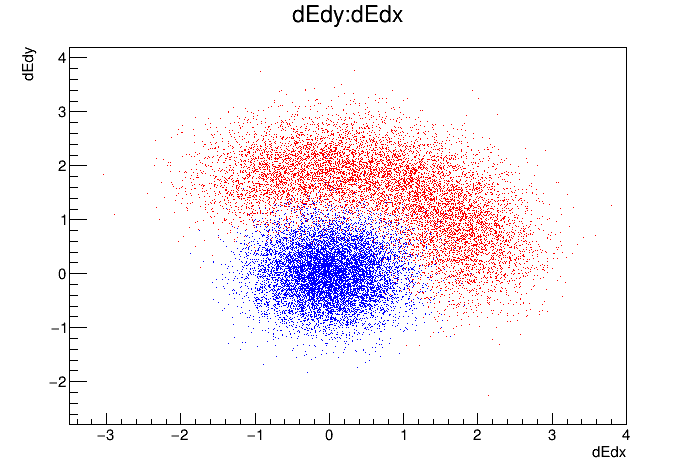

In [3]:
outfile = ROOT.TFile('InputFile.root')
TreeS = outfile.Get('Sig')
TreeB = outfile.Get('Bkg')
TreeB.SetMarkerColor(2)
TreeS.SetMarkerColor(4)

dummy = ROOT.TCanvas()
TreeB.Draw("dEdy:dEdx")
TreeS.Draw("dEdy:dEdx","","same")
dummy.Draw()

## Creating the Test statistics

We could use Fisher Discriminator to construct the test statitics for the above variables. The method is available in the TMVA module. 

In [4]:
outputFile = ROOT.TFile("TMVA.root","RECREATE")
factory = TMVA.Factory("tmvaTest", outputFile, "")
dataloader = TMVA.DataLoader("dataset")

inputFile = ROOT.TFile("InputFile.root")

# get the TTree objects from the input files

sig = inputFile.Get("Sig")
bkg = inputFile.Get("Bkg")
nSig = sig.GetEntries()
nBkg = bkg.GetEntries()


# global event weights (see below for setting event-wise weights)

sigWeight = 1.0
bkgWeight = 1.0


# dataloader.AddSignalTree(sigTest, sigWeight, TMVA.Types.kTesting)
# dataloader.AddBackgroundTree(bkgTest, bkgWeight, TMVA.Types.kTesting)

dataloader.AddVariable("dEdx", 'F')
dataloader.AddVariable("dEdy", 'F')

dataloader.AddSignalTree(sig, sigWeight)
dataloader.AddBackgroundTree(bkg, bkgWeight)
cut1 = ROOT.TCut("")
cut2 = ROOT.TCut("") 
dataloader.PrepareTrainingAndTestTree(cut1,"SplitMode=Random:!V")

# Book MVA methods (see TMVA manual).  
#factory.BookMethod(dataloader,TMVA.Types.kMLP, "MLP", "H:!V:HiddenLayers=3");  
factory.BookMethod(dataloader,TMVA.Types.kFisher, "Fisher", "H:!V:Fisher")
# Train, test and evaluate all methods

factory.TrainAllMethods()
factory.TestAllMethods()
factory.EvaluateAllMethods()



outputFile.Close()
print(' TMVAanalyses is done! ')


 TMVAanalyses is done! 
create data set info dataset
<HEADER> DataSetInfo              : [dataset] : Added class "Signal"
                         : Add Tree Sig of type Signal with 10000 events
<HEADER> DataSetInfo              : [dataset] : Added class "Background"
                         : Add Tree Bkg of type Background with 10000 events
                         : Dataset[dataset] : Class index : 0  name : Signal
                         : Dataset[dataset] : Class index : 1  name : Background
<HEADER> Factory                  : Booking method: Fisher
                         : 
<HEADER> Factory                  : Train all methods
                         : Building event vectors for type 2 Signal
                         : Dataset[dataset] :  create input formulas for tree Sig
                         : Building event vectors for type 2 Background
                         : Dataset[dataset] :  create input formulas for tree Bkg
<HEADER> DataSetFactory           : [dataset] : Numb

0%, time left: unknown
7%, time left: 0 sec
13%, time left: 0 sec
19%, time left: 0 sec
25%, time left: 0 sec
32%, time left: 0 sec
38%, time left: 0 sec
44%, time left: 0 sec
50%, time left: 0 sec
57%, time left: 0 sec
63%, time left: 0 sec
69%, time left: 0 sec
75%, time left: 0 sec
82%, time left: 0 sec
88%, time left: 0 sec
94%, time left: 0 sec
0%, time left: unknown
7%, time left: 0 sec
13%, time left: 0 sec
19%, time left: 0 sec
25%, time left: 0 sec
32%, time left: 0 sec
38%, time left: 0 sec
44%, time left: 0 sec
50%, time left: 0 sec
57%, time left: 0 sec
63%, time left: 0 sec
69%, time left: 0 sec
75%, time left: 0 sec
82%, time left: 0 sec
88%, time left: 0 sec
94%, time left: 0 sec


## Plotting test statitics

The Fisher weights stored in the 'dataset/weights/' directory as a xml file. One can use the weights to test the data using TMVA::reader. Here we already have the TestTree in the TMVA.root file, so we can plot the Test statitics. Inside the Tree test statitics stored as Fisher, and class ID discriminate Background( 1 for Bkg) and signal (0 for Signal).

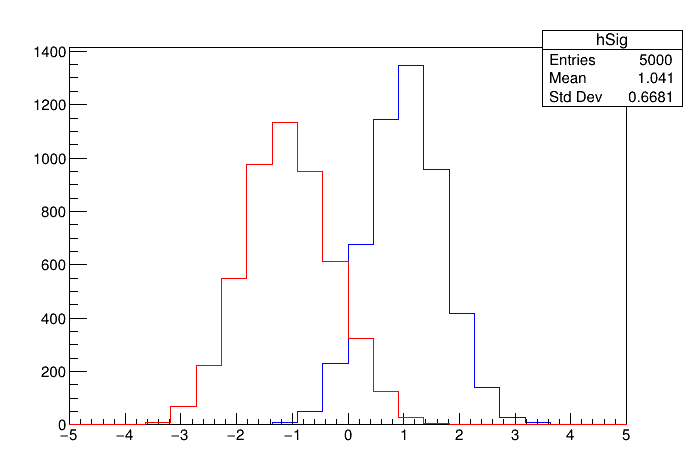

In [30]:
mvafile = ROOT.TFile('TMVA.root')
TestTree = mvafile.Get('/dataset/TestTree')

cc = ROOT.TCanvas()
hSig = ROOT.TH1D("hSig","",22,-5,5)
hBkg = ROOT.TH1D("hBkg","",22,-5,5)
hSig.SetLineColor(ROOT.kBlue)
hBkg.SetLineColor(ROOT.kRed)
TestTree.Draw("Fisher>>hSig","classID == 0")  # signal
TestTree.Draw("Fisher>>hBkg","classID == 1")  # background
hSig.Draw()
hBkg.Draw('same')
cc.Draw()



One can assume $t_{cut}$ some where and find the purity of detecting electron all in here. 

$\textbf{ NOTE: I will update the code for How to find better } t_{cut}\textbf{ later.}$